In [69]:
import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

In [30]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30

In [31]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [32]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c

    return kl_divergence, grad

In [33]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):

    params = X_embedded.ravel()
    
    obj_func = _kl_divergence
    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])
        
    X_embedded = params.reshape(n_samples, n_components)

    return X_embedded

In [37]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):

        error, grad = obj_func(p, *args)

        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break

    return p

In [38]:
X, y = load_digits(return_X_y=True)

In [39]:
X_embedded = fit(X)

[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000052
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000052
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000064
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000099
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000171
[t-SNE] Iteration 6: error = 4.0229673, gradient norm = 0.0000316
[t-SNE] Iteration 7: error = 4.0229665, gradient norm = 0.0000623
[t-SNE] Iteration 8: error = 4.0229628, gradient norm = 0.0001303
[t-SNE] Iteration 9: error = 4.0229450, gradient norm = 0.0002874
[t-SNE] Iteration 10: error = 4.0228495, gradient norm = 0.0006661
[t-SNE] Iteration 11: error = 4.0222889, gradient norm = 0.0016128
[t-SNE] Iteration 12: error = 4.0187345, gradient norm = 0.0040207
[t-SNE] Iteration 13: error = 3.9957638, gradient norm = 0.0096178
[t-SNE] Iteration 14: error = 3.8767494, gradient norm = 0.0172189
[t-SNE] Iteration 15: error = 3.5609423, gradient norm = 0.0186278
[t-S

[t-SNE] Iteration 124: error = 0.9270038, gradient norm = 0.0003858
[t-SNE] Iteration 125: error = 0.9254212, gradient norm = 0.0003819
[t-SNE] Iteration 126: error = 0.9238564, gradient norm = 0.0003710
[t-SNE] Iteration 127: error = 0.9223101, gradient norm = 0.0003795
[t-SNE] Iteration 128: error = 0.9207820, gradient norm = 0.0003828
[t-SNE] Iteration 129: error = 0.9192706, gradient norm = 0.0003679
[t-SNE] Iteration 130: error = 0.9177752, gradient norm = 0.0003590
[t-SNE] Iteration 131: error = 0.9162976, gradient norm = 0.0003611
[t-SNE] Iteration 132: error = 0.9148374, gradient norm = 0.0003563
[t-SNE] Iteration 133: error = 0.9133939, gradient norm = 0.0003442
[t-SNE] Iteration 134: error = 0.9119676, gradient norm = 0.0003464
[t-SNE] Iteration 135: error = 0.9105601, gradient norm = 0.0003526
[t-SNE] Iteration 136: error = 0.9091677, gradient norm = 0.0003591
[t-SNE] Iteration 137: error = 0.9077887, gradient norm = 0.0003476
[t-SNE] Iteration 138: error = 0.9064274, gradie

[t-SNE] Iteration 247: error = 0.7981235, gradient norm = 0.0003540
[t-SNE] Iteration 248: error = 0.7974531, gradient norm = 0.0003722
[t-SNE] Iteration 249: error = 0.7969906, gradient norm = 0.0004362
[t-SNE] Iteration 250: error = 0.7965375, gradient norm = 0.0004394
[t-SNE] Iteration 251: error = 0.7960400, gradient norm = 0.0003895
[t-SNE] Iteration 252: error = 0.7955501, gradient norm = 0.0003566
[t-SNE] Iteration 253: error = 0.7950645, gradient norm = 0.0003207
[t-SNE] Iteration 254: error = 0.7946227, gradient norm = 0.0003358
[t-SNE] Iteration 255: error = 0.7941671, gradient norm = 0.0003210
[t-SNE] Iteration 256: error = 0.7937106, gradient norm = 0.0003054
[t-SNE] Iteration 257: error = 0.7932614, gradient norm = 0.0002956
[t-SNE] Iteration 258: error = 0.7928135, gradient norm = 0.0002780
[t-SNE] Iteration 259: error = 0.7923702, gradient norm = 0.0002651
[t-SNE] Iteration 260: error = 0.7919328, gradient norm = 0.0002580
[t-SNE] Iteration 261: error = 0.7914977, gradie

[t-SNE] Iteration 370: error = 0.7556869, gradient norm = 0.0001182
[t-SNE] Iteration 371: error = 0.7554598, gradient norm = 0.0001259
[t-SNE] Iteration 372: error = 0.7552335, gradient norm = 0.0001214
[t-SNE] Iteration 373: error = 0.7550085, gradient norm = 0.0001221
[t-SNE] Iteration 374: error = 0.7547846, gradient norm = 0.0001192
[t-SNE] Iteration 375: error = 0.7545617, gradient norm = 0.0001180
[t-SNE] Iteration 376: error = 0.7543402, gradient norm = 0.0001180
[t-SNE] Iteration 377: error = 0.7541201, gradient norm = 0.0001184
[t-SNE] Iteration 378: error = 0.7539015, gradient norm = 0.0001181
[t-SNE] Iteration 379: error = 0.7536844, gradient norm = 0.0001125
[t-SNE] Iteration 380: error = 0.7534689, gradient norm = 0.0001137
[t-SNE] Iteration 381: error = 0.7532548, gradient norm = 0.0001179
[t-SNE] Iteration 382: error = 0.7530414, gradient norm = 0.0001166
[t-SNE] Iteration 383: error = 0.7528291, gradient norm = 0.0001132
[t-SNE] Iteration 384: error = 0.7526185, gradie

[t-SNE] Iteration 492: error = 0.7372974, gradient norm = 0.0000851
[t-SNE] Iteration 493: error = 0.7372023, gradient norm = 0.0000872
[t-SNE] Iteration 494: error = 0.7371074, gradient norm = 0.0000830
[t-SNE] Iteration 495: error = 0.7370130, gradient norm = 0.0000857
[t-SNE] Iteration 496: error = 0.7369191, gradient norm = 0.0000858
[t-SNE] Iteration 497: error = 0.7368254, gradient norm = 0.0000837
[t-SNE] Iteration 498: error = 0.7367320, gradient norm = 0.0000789
[t-SNE] Iteration 499: error = 0.7366391, gradient norm = 0.0000794
[t-SNE] Iteration 500: error = 0.7365466, gradient norm = 0.0000827
[t-SNE] Iteration 501: error = 0.7364544, gradient norm = 0.0000896
[t-SNE] Iteration 502: error = 0.7363626, gradient norm = 0.0000899
[t-SNE] Iteration 503: error = 0.7362708, gradient norm = 0.0000820
[t-SNE] Iteration 504: error = 0.7361796, gradient norm = 0.0000755
[t-SNE] Iteration 505: error = 0.7360890, gradient norm = 0.0000840
[t-SNE] Iteration 506: error = 0.7359986, gradie

[t-SNE] Iteration 614: error = 0.7279856, gradient norm = 0.0000672
[t-SNE] Iteration 615: error = 0.7279234, gradient norm = 0.0000676
[t-SNE] Iteration 616: error = 0.7278618, gradient norm = 0.0000774
[t-SNE] Iteration 617: error = 0.7278004, gradient norm = 0.0000890
[t-SNE] Iteration 618: error = 0.7277389, gradient norm = 0.0000914
[t-SNE] Iteration 619: error = 0.7276774, gradient norm = 0.0000755
[t-SNE] Iteration 620: error = 0.7276164, gradient norm = 0.0000712
[t-SNE] Iteration 621: error = 0.7275559, gradient norm = 0.0000824
[t-SNE] Iteration 622: error = 0.7274953, gradient norm = 0.0000700
[t-SNE] Iteration 623: error = 0.7274354, gradient norm = 0.0000767
[t-SNE] Iteration 624: error = 0.7273756, gradient norm = 0.0000764
[t-SNE] Iteration 625: error = 0.7273159, gradient norm = 0.0000704
[t-SNE] Iteration 626: error = 0.7272569, gradient norm = 0.0000755
[t-SNE] Iteration 627: error = 0.7271980, gradient norm = 0.0000736
[t-SNE] Iteration 628: error = 0.7271393, gradie

[t-SNE] Iteration 737: error = 0.7213494, gradient norm = 0.0000558
[t-SNE] Iteration 738: error = 0.7213041, gradient norm = 0.0000592
[t-SNE] Iteration 739: error = 0.7212590, gradient norm = 0.0000556
[t-SNE] Iteration 740: error = 0.7212140, gradient norm = 0.0000598
[t-SNE] Iteration 741: error = 0.7211689, gradient norm = 0.0000591
[t-SNE] Iteration 742: error = 0.7211238, gradient norm = 0.0000556
[t-SNE] Iteration 743: error = 0.7210788, gradient norm = 0.0000591
[t-SNE] Iteration 744: error = 0.7210337, gradient norm = 0.0000526
[t-SNE] Iteration 745: error = 0.7209884, gradient norm = 0.0000547
[t-SNE] Iteration 746: error = 0.7209428, gradient norm = 0.0000559
[t-SNE] Iteration 747: error = 0.7208964, gradient norm = 0.0000570
[t-SNE] Iteration 748: error = 0.7208491, gradient norm = 0.0000556
[t-SNE] Iteration 749: error = 0.7208005, gradient norm = 0.0000558
[t-SNE] Iteration 750: error = 0.7207499, gradient norm = 0.0000581
[t-SNE] Iteration 751: error = 0.7206963, gradie

[t-SNE] Iteration 860: error = 0.7160371, gradient norm = 0.0000504
[t-SNE] Iteration 861: error = 0.7160036, gradient norm = 0.0000558
[t-SNE] Iteration 862: error = 0.7159700, gradient norm = 0.0000522
[t-SNE] Iteration 863: error = 0.7159366, gradient norm = 0.0000503
[t-SNE] Iteration 864: error = 0.7159033, gradient norm = 0.0000529
[t-SNE] Iteration 865: error = 0.7158700, gradient norm = 0.0000516
[t-SNE] Iteration 866: error = 0.7158369, gradient norm = 0.0000527
[t-SNE] Iteration 867: error = 0.7158039, gradient norm = 0.0000463
[t-SNE] Iteration 868: error = 0.7157711, gradient norm = 0.0000520
[t-SNE] Iteration 869: error = 0.7157383, gradient norm = 0.0000477
[t-SNE] Iteration 870: error = 0.7157057, gradient norm = 0.0000542
[t-SNE] Iteration 871: error = 0.7156732, gradient norm = 0.0000518
[t-SNE] Iteration 872: error = 0.7156407, gradient norm = 0.0000504
[t-SNE] Iteration 873: error = 0.7156083, gradient norm = 0.0000457
[t-SNE] Iteration 874: error = 0.7155760, gradie

[t-SNE] Iteration 983: error = 0.7123063, gradient norm = 0.0000559
[t-SNE] Iteration 984: error = 0.7122783, gradient norm = 0.0000505
[t-SNE] Iteration 985: error = 0.7122504, gradient norm = 0.0000457
[t-SNE] Iteration 986: error = 0.7122227, gradient norm = 0.0000489
[t-SNE] Iteration 987: error = 0.7121949, gradient norm = 0.0000473
[t-SNE] Iteration 988: error = 0.7121674, gradient norm = 0.0000577
[t-SNE] Iteration 989: error = 0.7121397, gradient norm = 0.0000574
[t-SNE] Iteration 990: error = 0.7121122, gradient norm = 0.0000590
[t-SNE] Iteration 991: error = 0.7120846, gradient norm = 0.0000422
[t-SNE] Iteration 992: error = 0.7120574, gradient norm = 0.0000479
[t-SNE] Iteration 993: error = 0.7120302, gradient norm = 0.0000508
[t-SNE] Iteration 994: error = 0.7120031, gradient norm = 0.0000470
[t-SNE] Iteration 995: error = 0.7119761, gradient norm = 0.0000498
[t-SNE] Iteration 996: error = 0.7119491, gradient norm = 0.0000484
[t-SNE] Iteration 997: error = 0.7119223, gradie

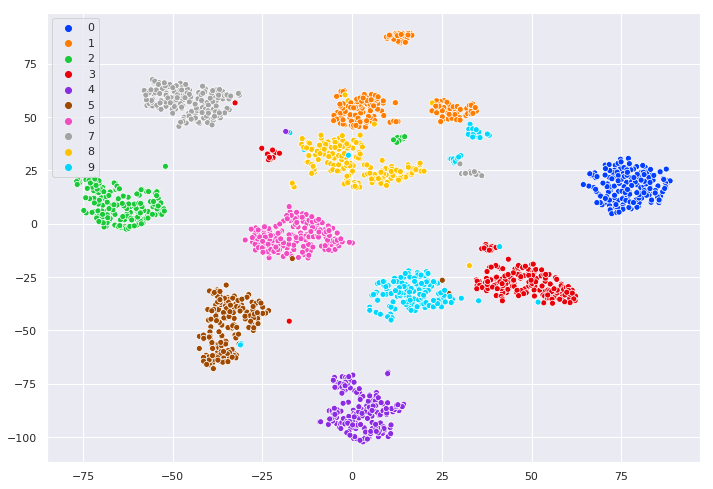

In [40]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [59]:
tsne = TSNE()

In [61]:
X_embedded = tsne.fit_transform(X)

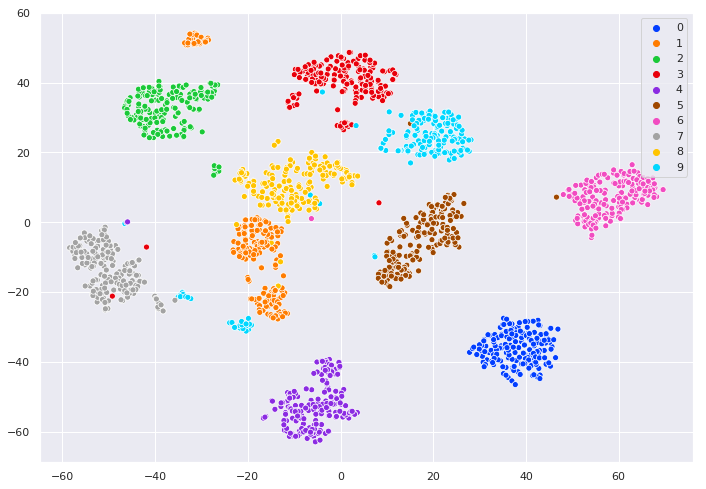

In [62]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

In [79]:
def plot_matrix_of_similarities(X_embedded):
    n_samples = X_embedded.shape[0]

    degrees_of_freedom = max(n_components - 1, 1)

    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    Q = squareform(Q)

    plt.imshow(Q, cmap=sns.light_palette("blue", as_cmap=True), aspect='auto')

In [80]:
X_random_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)

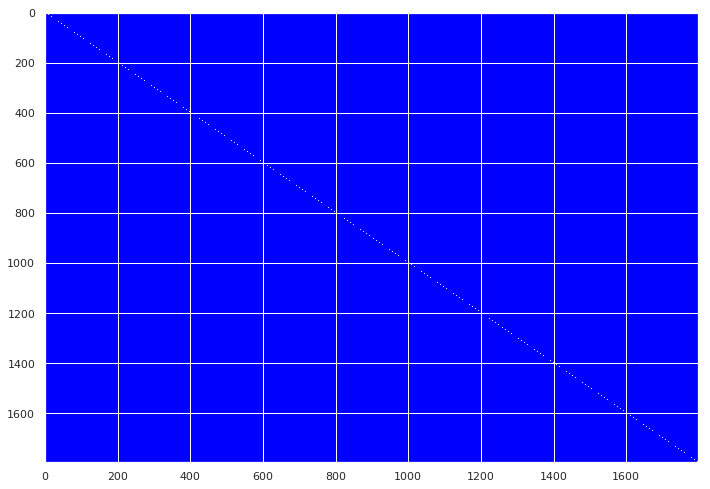

In [81]:
plot_matrix_of_similarities(X_random_embedded)

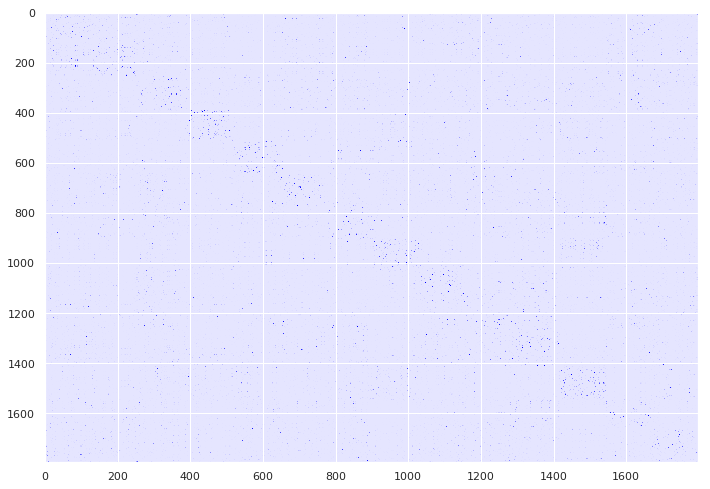

In [82]:
plot_matrix_of_similarities(X_embedded)